In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv001.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os
import numpy as np
import xarray as xr
import torch

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

sys.path.append('../../mre_ai')
#import mre_ai.mre_datasets

torch.cuda.is_available()

Using backend: pytorch



True

In [ ]:
nifti_dirs = [
    'MRE_DICOM_7-31-19',
    'MRE_DICOM_9-12-19',
    'MRE_DICOM_10-09-19',
    'MRE_DICOM_10-22-19'
]

sequences = [
    'dwi',
    'mre',
    'mre_mask',
    'mre_raw',
    'mre_wave',
    'mre_phase',
    #'t1_pos_0_fat',
    #'t1_pos_0_in',
    #'t1_pos_0_out',
    #'t1_pos_0_water',
    #'t1_pos_160_fat',
    #'t1_pos_160_in',
    #'t1_pos_160_out',
    #'t1_pos_160_water',
    #'t1_pos_300_fat',
    #'t1_pos_300_in',
    #'t1_pos_300_out',
    #'t1_pos_300_water',
    #'t1_pos_70_fat',
    #'t1_pos_70_in',
    #'t1_pos_70_out',
    #'t1_pos_70_water',
    #'t1_pre_fat',
    #'t1_pre_in',
    #'t1_pre_out',
    't1_pre_water',
    #'t2',
    'wave'
]

def load_nifti_metadata(nii_file):
    image = sitk.ReadImage(nii_file)
    dim = image.GetDimension()
    size = image.GetSize()
    origin = image.GetOrigin()
    spacing = image.GetSpacing()
    components = image.GetNumberOfComponentsPerPixel()
    type_ = image.GetPixelIDTypeAsString()
    return image, dim, size, origin, spacing, components, type_

import pandas as pd
index_cols = ['nifti_dir', 'patient_id', 'sequence']
df = pd.DataFrame(columns=index_cols).set_index(index_cols)

for nifti_dir in nifti_dirs[:1]:
    print(nifti_dir)
    nifti_dir = os.path.join(data_root, nifti_dir, 'NIFTI')
    patient_ids = sorted(os.listdir(nifti_dir))
    n_patient_ids = len(patient_ids)
    for i, patient_id in enumerate(patient_ids):
        print(f'  [{i+1} / {n_patient_ids}] {patient_id}')
        patient_dir = os.path.join(nifti_dir, patient_id)
        for nii_base in os.listdir(patient_dir):
            if not nii_base.endswith('.nii'):
                continue
            seq = os.path.splitext(nii_base)[0]
            idx = (nifti_dir, patient_id, seq)
            nii_file = os.path.join(nifti_dir, patient_id, nii_base)
            image = sitk.ReadImage(nii_file)
            df.loc[idx, 'dimension'] = image.GetDimension()
            df.loc[idx, 'size'] = str(image.GetSize())
            df.loc[idx, 'origin'] = str(image.GetOrigin())
            df.loc[idx, 'spacing'] = str(image.GetSpacing())
            df.loc[idx, 'components'] = image.GetNumberOfComponentsPerPixel()
            df.loc[idx, 'type'] = image.GetPixelIDTypeAsString()

df

In [ ]:
df.groupby('sequence').nunique()

In [ ]:
df.loc[:,:,['t1_pre_water','mre', 'wave']].groupby(['sequence', 'size']).count()

## Data processing steps

- load SITK images from NIFIT files
- perform filtering/inpainting on wave image
- register images wrt anatomical image
- load segmentation model
- perform image segmentation
- convert images to xarray Dataset

In [146]:
%autoreload
patient = mre_pinn.data.MREPatient(
    data_root='/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI',
    patient_id='0043',
    sequences=[
        't1_pre_in', 't1_pre_water', 't1_pre_out', 't1_pre_fat', 't2', 'mre_raw', 'wave', 'mre'
    ]
)
patient.load_images()
patient.metadata

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0043/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0043/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0043/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0043/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0043/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0043/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0043/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0043/mre.nii


size    spacing      origin       limit      center  \
sequence     dimension                                                        
t1_pre_in    0           512   0.703100 -176.651993  182.632120    2.990064   
             1           512   0.703100 -218.074005  141.210108  -38.431949   
             2            96   2.300003 -138.112000   80.388290  -28.861855   
t1_pre_water 0           512   0.703100 -176.651993  182.632120    2.990064   
             1           512   0.703100 -218.074005  141.210108  -38.431949   
             2            96   2.300003 -138.112000   80.388290  -28.861855   
t1_pre_out   0           512   0.703100 -176.651993  182.632120    2.990064   
             1           512   0.703100 -218.074005  141.210108  -38.431949   
             2            96   2.300003 -138.112000   80.388290  -28.861855   
t1_pre_fat   0           512   0.703100 -176.651993  182.632120    2.990064   
             1           512   0.703100 -218.074005  141.210108  -38.431949   
             2            96   2.300003 -138.112000   80.388290  -28.861855   
t2           0           256   1.406300 -168.722000  189.884487   10.581243   
             1           256   1.406300 -209.128006  149.478481  -29.824763   
             2            22  10.000000 -135.945999   74.054001  -30.945999   
mre_raw      0           256   1.406300 -177.684998  180.921489    1.618246   
             1           256   1.406300 -199.296997  159.309490  -19.993754   
             2             4   1.000000    0.000000    3.000000    1.500000   
wave         0           512   1.000000    0.000000  511.000000  255.500000   
             1           512   1.000000    0.000000  511.000000  255.500000   
             2             4   1.000000    0.000000    3.000000    1.500000   
mre          0           256   1.406300 -177.684998  180.921489    1.618246   
             1           256   1.406300 -199.296997  159.309490  -19.993754   
             2             4  11.000002   30.741400   63.741405   47.241403   

                            extent  
sequence     dimension              
t1_pre_in    0          359.987213  
             1          359.987213  
             2          220.800293  
t1_pre_water 0          359.987213  
             1          359.987213  
             2          220.800293  
t1_pre_out   0          359.987213  
             1          359.987213  
             2          220.800293  
t1_pre_fat   0          359.987213  
             1          359.987213  
             2          220.800293  
t2           0          360.012787  
             1          360.012787  
             2          220.000000  
mre_raw      0          360.012787  
             1          360.012787  
             2            4.000000  
wave         0          512.000000  
             1          512.000000  
             2            4.000000  
mre          0          360.012787  
             1          360.012787  
             2           44.000008

In [147]:
%autoreload
patient.preprocess_images(mask_seq='t2', model=model)

Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Resizing t1_pre_in to (256, 256, 32)
Resizing t1_pre_water to (256, 256, 32)
Resizing t1_pre_out to (256, 256, 32)
Resizing t1_pre_fat to (256, 256, 32)
Resizing t2 to (256, 256, 32)
Resizing mre_raw to (256, 256, 32)
Resizing wave to (256, 256, 32)
Resizing mre to (256, 256, 32)
Segmenting t2
Registering t1_pre_in to mre_raw
ELASTIX version: 5.000
Command line options from ElastixBase:
-fMask    unspecified, so no fixed mask used
-mMask    unspecified, so no moving mask used
-out      ./
-threads  unspecified, so all available threads are used
  The default value "true" is used instead.

  From elastix 4.8 it defaults to true!
This may change the behavior of your registrations considerably.

Command line options from TransformBase:
-t0       unspecified, so no initial transform used

Reading images...
Reading images took 0 ms.

  A default pyramid schedule is used.
  A default pyramid schedule is used.
  The def

80	-0.788026	0.202485	38.466240	0.006191	2.0
81	-0.805294	0.091738	38.668217	0.008205	3.4
82	-0.800012	0.000000	38.837137	0.008761	1.9
83	-0.842460	0.000000	38.837137	0.008213	2.2
84	-0.819072	0.000000	38.837137	0.005754	1.9
85	-0.810338	0.000000	38.837137	0.007559	1.9
86	-0.809516	0.000000	38.837137	0.005695	1.9
87	-0.786561	0.000000	38.837137	0.006059	2.1
88	-0.808353	0.000000	38.837137	0.007044	2.0
89	-0.835640	0.000000	38.837137	0.005494	1.8
90	-0.841101	0.000000	38.837137	0.008107	2.2
91	-0.829079	0.000000	38.837137	0.005692	2.2
92	-0.802930	0.000000	38.837137	0.005703	2.0
93	-0.821328	0.000000	38.837137	0.005171	2.0
94	-0.825451	0.000000	38.837137	0.005778	1.8
95	-0.837356	0.000000	38.837137	0.006270	2.0
96	-0.833480	0.000000	38.837137	0.007251	2.0
97	-0.851825	0.000000	38.837137	0.008350	2.3
98	-0.820787	0.000000	38.837137	0.008798	1.9
99	-0.838996	0.000000	38.837137	0.007458	1.8
100	-0.819519	0.000000	38.837137	0.006914	2.2
101	-0.816705	0.000000	38.837137	0.006530	2.1
102	-0.8

2	-0.741693	0.000000	27.745070	0.004915	3.6
3	-0.722028	0.000000	27.745070	0.002688	2.2
4	-0.783309	0.000000	27.745070	0.006778	2.1
5	-0.705859	0.000000	27.745070	0.005136	1.9
6	-0.737022	0.000000	27.745070	0.003319	2.3
7	-0.749980	0.000000	27.745070	0.004726	2.3
8	-0.738146	0.000000	27.745070	0.005592	1.9
9	-0.751205	0.000000	27.745070	0.007048	2.0
10	-0.736106	0.999897	26.484055	0.008505	2.1
11	-0.752460	1.999897	25.332569	0.004772	2.3
12	-0.766687	1.201177	26.243945	0.008653	2.0
13	-0.749531	0.401999	27.223928	0.002106	2.2
14	-0.775740	0.000000	27.745070	0.007749	1.9
15	-0.752982	0.001578	27.742986	0.006435	2.2
16	-0.747823	0.000000	27.745070	0.006110	2.1
17	-0.733582	0.999380	26.484677	0.011079	2.1
18	-0.771274	0.200191	27.483077	0.005448	2.2
19	-0.773729	1.200189	26.245114	0.005846	2.0
20	-0.763876	1.451591	25.951233	0.004316	2.2
21	-0.768807	2.426280	24.871490	0.005619	2.0
22	-0.762775	2.325218	24.979251	0.003026	2.1
23	-0.759114	2.894584	24.384040	0.006290	2.2
24	-0.735022	2.416

195	-0.741709	12.378236	17.455880	0.004948	3.1
196	-0.740579	13.165402	17.053699	0.004029	2.0
197	-0.752894	14.152704	16.574727	0.004348	2.2
198	-0.774999	15.142550	16.120791	0.004915	2.2
199	-0.744722	16.138322	15.688551	0.003635	2.0
200	-0.767451	15.633934	15.904557	0.005685	2.2
201	-0.764814	15.475612	15.973590	0.005790	2.1
202	-0.745169	14.676993	16.331155	0.005530	2.1
203	-0.758607	13.878473	16.705045	0.005783	2.0
204	-0.722744	13.105452	17.083676	0.005504	1.9
205	-0.766725	13.305036	16.984284	0.004667	2.0
206	-0.735262	14.201103	16.551938	0.004697	2.1
207	-0.762804	13.407937	16.933491	0.010087	2.0
208	-0.743208	14.407933	16.455253	0.001957	1.9
209	-0.761788	14.225364	16.540538	0.008897	1.9
210	-0.744374	14.429845	16.445076	0.007763	1.9
211	-0.770761	15.429842	15.993659	0.002958	2.1
212	-0.764931	16.194028	15.665055	0.005243	2.0
213	-0.755138	16.660262	15.471121	0.007582	2.2
214	-0.768823	15.861076	15.806551	0.004823	2.1
215	-0.735543	15.064637	16.155618	0.006262	2.0
216	-0.758336

19	-0.679073	0.816512	24.715771	0.006655	2.9
20	-0.692719	1.315952	24.162622	0.010319	1.9
21	-0.693434	0.572433	24.995415	0.004313	2.1
22	-0.703148	0.000000	25.676758	0.005070	2.0
23	-0.680614	0.937337	24.579643	0.003779	2.1
24	-0.697296	1.867894	23.579431	0.004438	2.2
25	-0.671160	1.211147	24.276635	0.008438	1.9
26	-0.665781	2.195384	23.246518	0.004494	2.0
27	-0.676098	2.149264	23.292832	0.005555	1.9
28	-0.687205	1.365271	24.109340	0.012483	2.0
29	-0.710819	0.580085	24.986552	0.004651	2.1
30	-0.675012	1.579976	23.880092	0.002582	2.3
31	-0.677117	2.207054	23.234829	0.002554	2.0
32	-0.699416	2.299835	23.142306	0.003562	1.8
33	-0.693276	1.717018	23.736034	0.010308	1.8
34	-0.676621	0.938967	24.577817	0.003296	2.0
35	-0.692261	1.859109	23.588492	0.003338	2.3
36	-0.712675	1.351148	24.124573	0.006316	2.0
37	-0.682220	0.587615	24.977836	0.002658	2.1
38	-0.707448	0.399243	25.197709	0.004017	2.1
39	-0.684951	0.000000	25.676758	0.003894	1.8
40	-0.720207	0.000000	25.676758	0.003887	1.9
41	-0.6776

215	-0.725532	10.944262	16.879774	0.005661	2.6
216	-0.695885	11.915153	16.381875	0.002586	1.9
217	-0.688039	11.544357	16.568522	0.010430	2.2
218	-0.713726	12.519857	16.086343	0.007267	2.0
219	-0.680640	12.069709	16.305312	0.007514	2.0
220	-0.710781	13.065586	15.828641	0.002727	1.9
221	-0.704152	12.401403	16.143391	0.007730	2.1
222	-0.693450	12.271422	16.206458	0.003338	1.8
223	-0.696115	13.176170	15.777424	0.006944	1.7
224	-0.694328	12.394422	16.146766	0.005777	1.9
225	-0.718848	11.609494	16.535427	0.009826	1.9
226	-0.734031	11.449884	16.616759	0.004364	1.8
227	-0.700118	12.447917	16.120941	0.007713	2.1
228	-0.675643	11.662910	16.508386	0.012812	2.0
229	-0.673582	10.877720	16.915009	0.012049	2.0
230	-0.714455	11.877720	16.400526	0.003072	2.0
231	-0.700808	11.093648	16.801204	0.004350	2.0
232	-0.728152	10.967916	16.867284	0.005110	1.9
233	-0.703396	10.210489	17.276625	0.002468	2.0
234	-0.673750	10.328586	17.211499	0.005196	2.1
235	-0.714629	9.790125	17.512495	0.006791	1.8
236	-0.703428	

40	-0.660424	4.175748	17.683908	0.004569	3.9
41	-0.661358	4.666783	17.345595	0.005857	2.0
42	-0.621533	4.010449	17.800785	0.006293	2.0
43	-0.658003	3.258407	18.352632	0.003715	2.1
44	-0.669158	2.655462	18.820415	0.008650	1.8
45	-0.639751	2.481967	18.959469	0.007075	2.0
46	-0.647617	1.969706	19.382295	0.010486	1.9
47	-0.684334	2.969621	18.573745	0.006007	1.9
48	-0.672489	3.715792	18.013002	0.004908	2.0
49	-0.663080	3.278630	18.337345	0.009938	2.2
50	-0.654863	3.011899	18.541042	0.005062	2.2
51	-0.667443	4.003899	17.805448	0.008865	2.0
52	-0.647611	3.246647	18.361533	0.005770	2.1
53	-0.655978	4.118320	17.724340	0.003469	2.2
54	-0.668469	3.925761	17.861265	0.005010	1.8
55	-0.661934	4.399722	17.527972	0.008407	2.0
56	-0.651894	3.669547	18.046769	0.014918	2.1
57	-0.676204	2.910164	18.619932	0.005410	1.9
58	-0.672915	3.909972	17.872586	0.003966	2.0
59	-0.680991	3.201932	18.395458	0.010853	1.8
60	-0.659235	3.938094	17.852432	0.002492	2.0
61	-0.644434	4.907245	17.184599	0.005819	2.0
62	-0.6643

235	-0.645295	21.786238	10.405346	0.006317	3.3
236	-0.655160	22.786236	10.167707	0.009736	2.2
237	-0.659870	23.786198	9.940688	0.006803	2.1
238	-0.708402	24.786116	9.723595	0.009447	2.2
239	-0.651249	24.026492	9.887637	0.004302	2.3
240	-0.662720	23.397147	10.027798	0.008321	2.2
241	-0.678583	22.896486	10.142170	0.004645	1.9
242	-0.659897	22.679115	10.192643	0.009285	2.0
243	-0.670598	23.359536	10.036300	0.004926	2.0
244	-0.656987	22.602146	10.210636	0.007449	2.0
245	-0.648094	22.583070	10.215105	0.004769	2.2
246	-0.676812	23.141321	10.085915	0.003657	1.9
247	-0.669591	22.637504	10.202362	0.015172	1.9
248	-0.648058	21.966900	10.361595	0.002944	2.0
249	-0.658962	21.347065	10.513258	0.007660	2.1
250	-0.680750	21.319368	10.520139	0.008055	2.0
251	-0.662253	22.317230	10.277795	0.006141	2.1
252	-0.622526	23.314752	10.046443	0.005777	1.9
253	-0.679466	22.564004	10.219576	0.007577	1.8
254	-0.639845	21.806912	10.400321	0.004427	1.8
255	-0.696472	21.052849	10.586813	0.004503	1.8
Time spent in re

84	-0.717438	0.783937	46.215590	0.003442	3.6
85	-0.690692	0.699829	46.394719	0.003602	2.0
86	-0.707823	0.615721	46.575243	0.003417	1.9
87	-0.686759	0.531614	46.757177	0.003958	2.2
88	-0.683492	0.447506	46.940539	0.004109	2.1
89	-0.722457	0.363398	47.125344	0.003536	2.0
90	-0.715955	0.279290	47.311610	0.004425	1.9
91	-0.713923	0.195183	47.499354	0.004068	2.0
92	-0.702987	0.111075	47.688594	0.004681	2.0
93	-0.697046	0.026979	47.879322	0.004657	2.0
94	-0.715409	0.000000	47.940832	0.006299	2.0
95	-0.722137	0.000000	47.940832	0.004991	2.1
96	-0.715309	0.000000	47.940832	0.005712	1.8
97	-0.679449	0.000000	47.940832	0.003925	2.1
98	-0.698841	0.000000	47.940832	0.004002	2.0
99	-0.678618	0.134545	47.635636	0.005413	1.8
100	-0.712442	0.050438	47.825964	0.006155	1.8
101	-0.701222	0.000000	47.940832	0.003890	1.8
102	-0.711883	0.000000	47.940832	0.004480	1.9
103	-0.719544	0.000000	47.940832	0.003447	2.0
104	-0.733065	0.000000	47.940832	0.004315	2.0
105	-0.712566	0.000000	47.940832	0.005196	2.1
106	

13	-0.607005	0.000000	53.767733	0.004124	3.7
14	-0.610296	0.878039	51.609853	0.007862	2.0
15	-0.630153	1.878036	49.353991	0.005221	2.0
16	-0.600465	1.409458	50.385976	0.005478	2.0
17	-0.601093	0.941205	51.461276	0.006315	2.0
18	-0.621740	0.472626	52.584273	0.003058	1.9
19	-0.618087	0.004064	53.757331	0.006858	2.0
20	-0.633801	0.000000	53.767733	0.006888	2.0
21	-0.613169	1.000000	51.323745	0.003526	1.9
22	-0.616937	1.990041	49.113543	0.006213	2.2
23	-0.621648	1.522648	50.132756	0.007232	1.9
24	-0.614371	1.054078	51.197895	0.003843	2.0
25	-0.616544	0.703477	52.024954	0.004795	2.0
26	-0.616340	0.267535	53.091361	0.008492	1.9
27	-0.583173	1.170855	50.928229	0.003864	2.2
28	-0.611492	0.702333	52.027696	0.005624	2.0
29	-0.633325	1.643884	49.864343	0.003963	1.9
30	-0.601840	1.175317	50.917982	0.007868	1.9
31	-0.625525	0.706739	52.017136	0.004222	2.3
32	-0.617060	1.151496	50.972737	0.005881	2.2
33	-0.603966	0.702865	52.026420	0.006701	2.3
34	-0.649825	0.234286	53.174493	0.002353	2.1
35	-0.6190

209	-0.651463	32.048192	21.284842	0.004046	3.2
210	-0.611940	31.579613	21.474528	0.002783	1.8
211	-0.623745	31.114276	21.666278	0.002258	1.8
212	-0.625601	30.659019	21.857217	0.004382	1.9
213	-0.638404	30.589196	21.886800	0.008197	2.1
214	-0.620466	30.120616	22.087417	0.005472	2.0
215	-0.627505	31.120616	21.663642	0.002870	1.9
216	-0.640332	31.508773	21.503500	0.007027	1.9
217	-0.631339	31.040328	21.697065	0.002333	1.9
218	-0.653167	30.572164	21.894028	0.004868	1.8
219	-0.667787	31.543502	21.489287	0.004489	2.0
220	-0.625544	32.543276	21.088034	0.003180	2.1
221	-0.606970	32.086518	21.269476	0.003934	2.1
222	-0.606358	31.618176	21.458790	0.003378	1.8
223	-0.615642	31.300261	21.589230	0.007869	1.9
224	-0.669911	30.831682	21.784406	0.002431	2.1
225	-0.668548	31.831530	21.372131	0.007580	2.3
226	-0.616938	31.362973	21.563375	0.003328	2.2
227	-0.659970	31.309945	21.585234	0.003260	2.2
228	-0.608537	32.100396	21.263917	0.004337	2.2
229	-0.609016	33.100354	20.870888	0.006083	2.0
230	-0.618659

33	-0.543113	4.590261	42.970578	0.007495	4.0
34	-0.553367	4.978065	42.329108	0.005436	2.2
35	-0.542695	5.977443	40.761027	0.002698	2.1
36	-0.544068	5.473961	41.536221	0.006431	1.9
37	-0.523411	6.303529	40.274219	0.004464	2.1
38	-0.554815	5.794427	41.039440	0.004245	2.0
39	-0.560969	6.794415	39.562923	0.007903	2.1
40	-0.525521	6.286634	40.299155	0.003536	2.2
41	-0.535158	5.816510	41.005645	0.005507	2.1
42	-0.550524	5.360306	41.715309	0.010139	1.9
43	-0.502792	6.360304	40.190646	0.004148	1.9
44	-0.532634	7.360011	38.773903	0.007640	1.9
45	-0.519927	6.851037	39.482490	0.003970	2.1
46	-0.533644	6.341936	40.217646	0.006765	1.9
47	-0.540152	7.341891	38.798691	0.006599	2.0
48	-0.547418	8.341891	37.476394	0.001545	2.0
49	-0.534638	8.088549	37.802789	0.014531	1.9
50	-0.511956	7.579774	38.475752	0.006093	1.8
51	-0.537500	7.070672	39.173564	0.008803	2.1
52	-0.522973	8.070672	37.826036	0.013865	2.1
53	-0.532840	9.070672	36.568131	0.007411	2.0
54	-0.548566	8.561571	37.197898	0.008273	1.8
55	-0.5582

230	-0.553856	54.819039	14.503327	0.008462	2.8
231	-0.530744	54.311366	14.601093	0.007245	1.9
232	-0.536199	53.802265	14.700468	0.005010	2.1
233	-0.530941	54.796491	14.507641	0.005801	2.2
234	-0.519796	55.796366	14.318754	0.011282	2.2
235	-0.551438	56.796366	14.134700	0.004998	2.2
236	-0.529774	56.287264	14.227807	0.005755	1.9
237	-0.563050	55.782025	14.321429	0.008603	1.9
238	-0.523729	55.272923	14.417020	0.004810	2.1
239	-0.534329	54.763822	14.513897	0.005758	2.3
240	-0.546340	55.763822	14.324825	0.009020	2.1
241	-0.530048	56.685972	14.154786	0.013211	1.9
242	-0.512170	57.685972	13.974896	0.004642	2.1
243	-0.557480	58.685972	13.799522	0.009488	2.1
244	-0.541219	59.685971	13.628494	0.011520	2.2
245	-0.525011	60.685971	13.461654	0.013431	2.2
246	-0.536075	61.685971	13.298850	0.007366	2.1
247	-0.548917	62.685971	13.139936	0.002914	2.2
248	-0.509650	63.338290	13.038304	0.006978	1.9
249	-0.521168	62.829250	13.117477	0.011054	1.9
250	-0.544036	62.320149	13.197628	0.006529	1.9
251	-0.507577

53	-0.457702	3.525318	13.971945	0.015514	3.5
54	-0.454242	4.525318	13.424569	0.008308	2.0
55	-0.467483	5.524820	12.918708	0.009405	2.0
56	-0.480369	6.293969	12.554656	0.011556	1.7
57	-0.473542	7.293958	12.110939	0.012347	2.1
58	-0.481061	8.293808	11.697571	0.008395	2.1
59	-0.470975	7.420681	12.056938	0.009984	2.2
60	-0.473216	6.547406	12.439153	0.005354	1.9
61	-0.496855	7.196532	12.152785	0.006013	2.1
62	-0.492127	6.928801	12.269284	0.013544	2.0
63	-0.464573	6.320695	12.542375	0.005568	2.1
64	-0.466632	5.575974	12.893842	0.007403	2.0
65	-0.475939	5.851745	12.761420	0.012148	1.9
66	-0.453731	4.979490	13.189882	0.006284	2.1
67	-0.483639	4.106275	13.648636	0.007471	2.0
68	-0.490824	4.311933	13.537741	0.006860	2.1
69	-0.476994	5.084863	13.136600	0.015636	2.1
70	-0.489523	6.084588	12.651711	0.012062	2.2
71	-0.478062	5.245278	13.056307	0.005669	2.2
72	-0.471354	6.244352	12.577521	0.004349	2.0
73	-0.467575	6.843101	12.307049	0.013532	2.2
74	-0.490105	7.028483	12.225649	0.012403	2.0
75	-0.4481

248	-0.497249	33.191436	6.323257	0.005489	3.5
249	-0.471714	34.160977	6.212116	0.016260	2.0
250	-0.463212	34.113643	6.217451	0.013353	1.9
251	-0.483380	35.113101	6.106709	0.010617	2.0
252	-0.465315	34.239822	6.203250	0.004742	1.9
253	-0.480112	33.385059	6.300745	0.008461	1.8
254	-0.464985	32.579167	6.395516	0.006227	1.9
255	-0.488065	33.577709	6.278505	0.011592	1.9
Time spent in resolution 3 (ITK initialization and iterating): 0.568 s.
Stopping condition: Maximum number of iterations has been reached.
Settings of AdaptiveStochasticGradientDescent in resolution 3:
( SP_a 342.666399 )
( SP_A 20.000000 )
( SP_alpha 1.000000 )
( SigmoidMax 1.000000 )
( SigmoidMin -0.873279 )
( SigmoidScale 0.000005 )



Creating the TransformParameterFile took 0.00s

Registration result checksum: 2457678015

Final metric value  = -0.488065
Settings of AdaptiveStochasticGradientDescent for all resolutions:
( SP_a 1006.757478 1129.122394 1099.628293 342.666399 )
( SP_A 20.000000 20.000000 20.000000 20.000000

85	-0.791150	0.000000	32.742539	0.007031	2.3
86	-0.798624	0.000000	32.742539	0.006339	3.0
87	-0.760158	0.000000	32.742539	0.007604	1.9
88	-0.795861	0.000000	32.742539	0.008800	2.3
89	-0.819906	0.000000	32.742539	0.007557	2.1
90	-0.826037	0.000000	32.742539	0.006700	2.0
91	-0.808809	0.000000	32.742539	0.006564	2.1
92	-0.782006	0.000000	32.742539	0.006302	1.9
93	-0.815175	0.000000	32.742539	0.006284	1.9
94	-0.805901	0.000000	32.742539	0.006992	1.9
95	-0.827975	0.000000	32.742539	0.007122	1.9
96	-0.819028	0.000000	32.742539	0.007180	1.9
97	-0.826231	0.000000	32.742539	0.007553	2.2
98	-0.814575	0.000000	32.742539	0.007716	1.9
99	-0.816782	0.000000	32.742539	0.006378	1.8
100	-0.817845	0.000000	32.742539	0.011845	2.0
101	-0.816035	0.000000	32.742539	0.009349	1.9
102	-0.813998	0.000000	32.742539	0.006127	1.9
103	-0.838178	0.000000	32.742539	0.007923	1.9
104	-0.819703	0.000000	32.742539	0.008904	1.9
105	-0.821469	0.000000	32.742539	0.006129	2.1
106	-0.818895	0.000000	32.742539	0.007351	2.1
107

14	-0.780604	0.000000	37.155989	0.010583	2.6
15	-0.752009	1.000000	35.467081	0.003970	2.0
16	-0.753637	2.000000	33.925034	0.006539	1.9
17	-0.741273	1.255051	35.060615	0.008350	2.0
18	-0.771994	0.510100	36.274855	0.007479	1.8
19	-0.774864	1.510100	34.663363	0.007630	2.1
20	-0.761380	1.444817	34.764185	0.003511	1.9
21	-0.769004	0.717211	35.928912	0.005454	1.9
22	-0.768603	1.500055	34.678838	0.013904	2.0
23	-0.763870	0.956948	35.536622	0.008453	2.1
24	-0.743837	0.211998	36.784644	0.013497	1.9
25	-0.777237	1.211998	35.128573	0.003268	1.8
26	-0.744372	2.205088	33.625203	0.010625	2.0
27	-0.741173	1.460139	34.740470	0.004158	1.9
28	-0.727610	0.715188	35.932260	0.005317	1.9
29	-0.766828	1.294133	34.999152	0.009092	2.2
30	-0.742690	0.549183	36.209066	0.007535	1.8
31	-0.741521	1.549183	34.603284	0.003679	2.1
32	-0.789448	0.804242	35.785503	0.008504	2.0
33	-0.747122	0.122210	36.941010	0.005826	1.9
34	-0.763070	1.122207	35.271153	0.002693	1.9
35	-0.753617	2.047464	33.855168	0.004955	1.8
36	-0.7409

221	-0.758678	25.789877	16.676166	0.004821	2.7
222	-0.783528	25.199528	16.889259	0.002936	2.0
223	-0.757958	25.067098	16.937811	0.008581	2.1
224	-0.775929	26.061055	16.580074	0.002089	2.2
225	-0.785927	26.168533	16.542295	0.004007	1.9
226	-0.773621	26.315285	16.490987	0.007192	2.2
227	-0.768907	27.315252	16.149678	0.003211	2.2
228	-0.752702	26.570378	16.402556	0.002262	2.2
229	-0.784680	25.956836	16.616873	0.004338	1.9
230	-0.782180	26.024251	16.593050	0.004358	2.0
231	-0.774982	26.937586	16.276910	0.007493	2.1
232	-0.778412	26.192636	16.533846	0.004136	2.0
233	-0.772706	25.447698	16.799019	0.007366	2.0
234	-0.741764	24.702753	17.072840	0.006542	2.0
235	-0.812815	23.957802	17.355736	0.006259	1.9
236	-0.769532	23.212852	17.648167	0.003982	1.9
237	-0.786430	22.467910	17.950616	0.006382	2.1
238	-0.769744	23.467854	17.546963	0.005705	1.9
239	-0.793198	22.722903	17.845928	0.009656	1.8
240	-0.760228	21.977952	18.155257	0.008918	2.0
241	-0.769234	22.977952	17.742431	0.003403	2.0
242	-0.750296

48	-0.698482	0.569244	23.704175	0.004764	3.0
49	-0.726140	1.557204	22.665980	0.009946	2.0
50	-0.677341	2.478950	21.776150	0.007075	1.9
51	-0.718560	3.478870	20.886632	0.005392	2.0
52	-0.680539	2.761886	21.516858	0.006474	2.0
53	-0.691193	2.650195	21.618475	0.003100	2.2
54	-0.684193	2.247918	21.992555	0.003033	2.1
55	-0.701239	2.061758	22.170085	0.011803	2.1
56	-0.692528	1.499113	22.724502	0.004473	2.2
57	-0.673899	2.498563	21.757975	0.006327	2.2
58	-0.680145	1.814188	22.410665	0.009995	1.9
59	-0.672111	2.814073	21.469706	0.004746	2.1
60	-0.700029	3.798361	20.617538	0.004743	2.1
61	-0.665732	4.341175	20.175905	0.007325	1.9
62	-0.694896	5.307036	19.435148	0.009996	2.2
63	-0.687045	4.589259	19.980303	0.006744	2.1
64	-0.693206	3.919024	20.517703	0.006997	1.8
65	-0.673463	4.908992	19.733733	0.002305	1.9
66	-0.672277	5.480109	19.308121	0.005003	1.9
67	-0.699641	5.072445	19.610019	0.008443	1.8
68	-0.694090	5.929339	18.986026	0.005823	2.0
69	-0.705856	5.211628	19.505890	0.004979	1.9
70	-0.6805

248	-0.694289	8.630476	17.255246	0.006869	3.1
249	-0.703276	9.630475	16.691910	0.004862	2.2
250	-0.721267	9.831052	16.583318	0.004919	1.8
251	-0.698575	9.984073	16.501418	0.009429	2.1
252	-0.670728	10.974994	15.990030	0.011639	2.1
253	-0.668015	10.257217	16.357219	0.006984	1.8
254	-0.677927	11.257216	15.850132	0.005132	2.0
255	-0.704057	12.251454	15.376204	0.003006	1.8
Time spent in resolution 2 (ITK initialization and iterating): 0.554 s.
Stopping condition: Maximum number of iterations has been reached.
Settings of AdaptiveStochasticGradientDescent in resolution 2:
( SP_a 511.281134 )
( SP_A 20.000000 )
( SP_alpha 1.000000 )
( SigmoidMax 1.000000 )
( SigmoidMin -0.717778 )
( SigmoidScale 0.000005 )


Resolution: 3
  The default value "false" is used instead.
  The default value "true" is used instead.
Setting the fixed masks took: 0 ms.
Setting the moving masks took: 0 ms.
  The default value "1" is used instead.
  The default value "false" is used instead.
  The default value "32" i

74	-0.641683	7.200612	19.231502	0.005470	4.1
75	-0.643903	6.650280	19.614272	0.009266	2.2
76	-0.640429	7.630003	18.943070	0.005145	1.9
77	-0.640640	7.099057	19.301008	0.004639	2.0
78	-0.644788	7.810037	18.824694	0.010485	2.1
79	-0.650940	7.334735	19.140469	0.009612	2.1
80	-0.652843	8.327843	18.492329	0.011558	1.9
81	-0.636731	9.327843	17.882582	0.010875	2.1
82	-0.630487	10.327842	17.311761	0.004403	2.1
83	-0.633573	9.767875	17.626831	0.008428	2.0
84	-0.624770	9.232830	17.938781	0.013197	2.1
85	-0.639046	10.227526	17.367374	0.007336	1.9
86	-0.668856	9.667330	17.684622	0.017798	1.8
87	-0.655166	10.667330	17.126172	0.010454	1.9
88	-0.636759	10.107141	17.434586	0.007489	1.9
89	-0.646500	9.546942	17.754318	0.008546	1.9
90	-0.639168	10.546717	17.191650	0.012211	2.1
91	-0.636078	9.986518	17.502455	0.007643	2.1
92	-0.666584	10.986516	16.955273	0.009611	2.0
93	-0.643064	11.986499	16.441276	0.017034	1.9
94	-0.673172	12.986418	15.957555	0.004038	1.8
95	-0.655857	12.426906	16.224658	0.007579	2.0
9


Final metric value  = -0.665266
Settings of AdaptiveStochasticGradientDescent for all resolutions:
( SP_a 687.593318 780.275772 511.281134 542.340129 )
( SP_A 20.000000 20.000000 20.000000 20.000000 )
( SP_alpha 1.000000 1.000000 1.000000 1.000000 )
( SigmoidMax 1.000000 1.000000 1.000000 1.000000 )
( SigmoidMin -0.086626 -0.744951 -0.717778 -0.560200 )
( SigmoidScale 0.000001 0.000002 0.000005 0.000005 )

Time spent on saving the results, applying the final transform etc.: 329 ms.
Registering t1_pre_fat to mre_raw
ELASTIX version: 5.000
Command line options from ElastixBase:
-fMask    unspecified, so no fixed mask used
-mMask    unspecified, so no moving mask used
-out      ./
-threads  unspecified, so all available threads are used
  The default value "true" is used instead.

  From elastix 4.8 it defaults to true!
This may change the behavior of your registrations considerably.

Command line options from TransformBase:
-t0       unspecified, so no initial transform used

Reading im

81	-0.558011	0.330490	35.251031	0.005862	2.5
82	-0.563809	0.214362	35.443996	0.005560	2.2
83	-0.581151	0.083957	35.663218	0.004483	2.0
84	-0.547577	0.000000	35.805798	0.005892	1.8
85	-0.567646	0.000000	35.805798	0.004929	1.9
86	-0.561014	0.000000	35.805798	0.005615	1.8
87	-0.526748	0.000000	35.805798	0.004042	1.9
88	-0.571915	0.000000	35.805798	0.004717	1.9
89	-0.569038	0.000000	35.805798	0.003736	2.0
90	-0.565654	0.000000	35.805798	0.004555	2.1
91	-0.545081	0.000000	35.805798	0.004451	2.1
92	-0.536330	0.000000	35.805798	0.005278	2.0
93	-0.558149	0.000000	35.805798	0.006748	2.0
94	-0.560394	0.000000	35.805798	0.004001	2.1
95	-0.588446	0.000000	35.805798	0.007334	1.9
96	-0.574863	0.000000	35.805798	0.005281	2.0
97	-0.575548	0.000000	35.805798	0.007128	2.0
98	-0.594028	0.000000	35.805798	0.004931	2.0
99	-0.589533	0.000000	35.805798	0.009355	2.1
100	-0.556752	0.000000	35.805798	0.004973	1.9
101	-0.563943	0.000000	35.805798	0.005092	2.0
102	-0.560616	0.000000	35.805798	0.007321	1.9
103	-0.

3	-0.462027	1.950307	27.079002	0.003620	2.3
4	-0.501525	1.089903	28.133731	0.010340	3.5
5	-0.439614	2.089903	26.915288	0.008368	2.3
6	-0.465401	1.217735	27.971861	0.003148	1.8
7	-0.447664	0.345570	29.114772	0.003660	1.9
8	-0.477093	0.032522	29.548116	0.004826	2.1
9	-0.471515	1.027748	28.213116	0.005880	2.1
10	-0.462954	1.994786	27.026623	0.011475	2.2
11	-0.484566	2.994786	25.900269	0.009918	2.1
12	-0.461238	2.122638	26.877185	0.006425	2.2
13	-0.453256	3.015579	25.877844	0.006906	2.1
14	-0.499174	2.143411	26.853060	0.003923	1.8
15	-0.435464	3.098419	25.788887	0.016725	2.0
16	-0.465390	2.226252	26.757284	0.002799	2.0
17	-0.466860	1.354084	27.801247	0.003147	2.0
18	-0.476422	2.026813	26.989032	0.005697	2.1
19	-0.504694	3.014652	25.878843	0.003145	2.2
20	-0.480195	2.142722	26.853859	0.002510	2.1
21	-0.468485	1.314855	27.850120	0.003662	2.0
22	-0.474848	2.218567	26.766140	0.005745	1.9
23	-0.468351	2.918208	25.983193	0.004302	2.0
24	-0.457850	3.917302	24.941360	0.004326	2.2
25	-0.483898	3.04

197	-0.472752	12.174277	18.733533	0.004811	2.5
198	-0.497567	13.021585	18.266974	0.007318	2.0
199	-0.461227	14.021585	17.745382	0.008721	2.0
200	-0.474302	15.021585	17.252750	0.008214	2.0
201	-0.483033	16.021576	16.786735	0.004522	2.2
202	-0.491530	15.149409	17.191745	0.006253	2.2
203	-0.470291	14.277242	17.616780	0.004794	2.2
204	-0.448596	15.277242	17.131165	0.004390	2.0
205	-0.483515	14.405086	17.553167	0.002305	2.2
206	-0.456927	15.208457	17.163709	0.001990	2.2
207	-0.471548	14.450567	17.530648	0.003433	2.2
208	-0.462096	13.988574	17.762124	0.010118	1.9
209	-0.462222	14.988552	17.268586	0.005645	2.1
210	-0.474947	14.116384	17.697477	0.002808	1.9
211	-0.485953	13.244568	18.148029	0.003811	1.9
212	-0.488566	14.227229	17.641791	0.007767	2.0
213	-0.456545	15.226891	17.154975	0.006614	2.0
214	-0.471937	14.354723	17.578172	0.007522	2.1
215	-0.465627	13.482560	18.022774	0.003527	2.1
216	-0.475848	12.685039	18.449479	0.006581	2.0
217	-0.466433	11.812893	18.939854	0.004501	2.1
218	-0.493739

22	-0.406065	1.225520	26.213598	0.003544	3.4
23	-0.404987	0.404244	27.219409	0.013671	2.0
24	-0.394904	0.000000	27.743374	0.004295	2.2
25	-0.389056	0.000000	27.743374	0.004617	2.1
26	-0.376914	0.000000	27.743374	0.014154	2.1
27	-0.393670	1.000000	26.482312	0.011029	2.0
28	-0.389288	2.000000	25.330907	0.009118	2.3
29	-0.425729	1.176241	26.271850	0.022502	2.2
30	-0.382703	0.666848	26.889507	0.009412	2.0
31	-0.384152	0.000000	27.743374	0.011079	2.1
32	-0.376705	0.000000	27.743374	0.017577	1.9
33	-0.412002	1.000000	26.482312	0.014037	2.2
34	-0.382100	2.000000	25.330907	0.014209	1.9
35	-0.389640	3.000000	24.275452	0.002561	2.2
36	-0.404219	3.998053	23.306249	0.015216	2.0
37	-0.382830	3.174699	24.100025	0.005316	2.0
38	-0.399069	4.174519	23.142880	0.006539	2.1
39	-0.378907	3.351860	23.924696	0.015176	2.2
40	-0.413488	4.351860	22.980990	0.004691	1.9
41	-0.410806	5.348175	22.112001	0.007837	2.1
42	-0.384198	6.347633	21.303886	0.005672	2.0
43	-0.378961	7.347630	20.552366	0.011316	1.9
44	-0.4170

216	-0.397640	17.597578	15.094493	0.005595	3.1
217	-0.376097	16.773821	15.423668	0.009749	1.9
218	-0.376952	17.773820	15.025882	0.003708	1.9
219	-0.387862	18.611854	14.707993	0.007749	2.2
220	-0.392400	17.796593	15.017062	0.007549	2.0
221	-0.387817	16.974008	15.342359	0.010255	2.1
222	-0.386910	16.150250	15.682556	0.008632	2.3
223	-0.409855	17.150250	15.271482	0.012999	2.1
224	-0.375866	16.326566	15.608477	0.002268	2.0
225	-0.403180	15.502841	15.960699	0.010610	1.9
226	-0.412661	16.482872	15.543389	0.012574	2.1
227	-0.377432	17.482872	15.139485	0.007740	2.0
228	-0.368533	18.482872	14.756041	0.004706	2.0
229	-0.386118	17.659189	15.070436	0.014272	2.2
230	-0.413258	18.659189	14.690438	0.006151	2.1
231	-0.407676	19.659189	14.329131	0.003858	2.0
232	-0.402924	18.840723	14.623501	0.005750	1.9
233	-0.399839	18.018074	14.931820	0.024494	2.2
234	-0.375747	17.194660	15.253726	0.010727	1.9
235	-0.400665	18.194660	14.864547	0.011046	2.1
236	-0.395550	17.370900	15.183664	0.005936	2.0
237	-0.392625

39	-0.325637	0.000000	23.503730	0.010542	3.2
40	-0.344840	0.000000	23.503730	0.005614	2.1
41	-0.341084	0.000000	23.503730	0.008960	1.9
42	-0.315999	0.000000	23.503730	0.009557	1.9
43	-0.335007	0.982637	22.453099	0.004944	2.2
44	-0.338889	1.325445	22.108332	0.007635	1.9
45	-0.343547	0.799661	22.641560	0.017488	1.8
46	-0.334868	1.799661	21.648495	0.008744	2.1
47	-0.330785	1.114987	22.318726	0.005712	2.0
48	-0.348314	0.831541	22.608497	0.004085	2.2
49	-0.328489	0.488873	22.969019	0.014611	2.0
50	-0.331248	0.000000	23.503730	0.016741	2.0
51	-0.355220	0.000000	23.503730	0.018871	2.2
52	-0.329391	1.000000	22.435379	0.012729	2.2
53	-0.339014	2.000000	21.459928	0.009617	2.0
54	-0.334055	2.999988	20.565775	0.016216	2.0
55	-0.345167	3.966903	19.769306	0.006771	2.3
56	-0.357973	4.966805	19.008050	0.013857	2.4
57	-0.344056	4.282133	19.522812	0.015959	2.2
58	-0.349391	5.282130	18.779997	0.003460	2.1
59	-0.357502	4.605047	19.276604	0.016289	1.9
60	-0.331420	5.527861	18.606036	0.014339	2.0
61	-0.3330

235	-0.323056	37.930250	8.375636	0.010744	2.9
236	-0.355794	38.922862	8.236895	0.011452	2.1
237	-0.324119	38.238192	8.332097	0.007819	1.9
238	-0.378129	38.717893	8.265167	0.014529	2.0
239	-0.333269	39.717892	8.129043	0.007474	2.2
240	-0.342923	40.687345	8.001290	0.008359	2.2
241	-0.337998	41.658761	7.877244	0.005231	2.0
242	-0.332401	41.648223	7.878569	0.008436	2.0
243	-0.339089	40.965490	7.965375	0.010378	2.1
244	-0.357698	41.965166	7.838911	0.011059	2.0
245	-0.317760	42.393242	7.785977	0.004299	1.9
246	-0.346129	43.392633	7.665137	0.013534	2.0
247	-0.342082	42.708032	7.747506	0.002819	1.9
248	-0.325669	42.640917	7.755676	0.014790	2.0
249	-0.331455	42.126337	7.818897	0.004631	2.0
250	-0.352809	42.691257	7.749546	0.006091	2.2
251	-0.339302	42.015012	7.832710	0.009412	1.9
252	-0.331910	43.013691	7.710512	0.011339	1.9
253	-0.364078	42.329036	7.793871	0.013013	1.9
254	-0.345022	41.644363	7.879054	0.006390	2.0
255	-0.350108	41.019865	7.958391	0.003776	1.9
Time spent in resolution 3 (ITK in

85	-0.759750	1.615534	39.113739	0.007939	3.8
86	-0.762991	2.615533	37.457469	0.005174	2.0
87	-0.737874	3.607508	35.947489	0.004420	1.9
88	-0.773857	3.387947	36.271118	0.007635	1.9
89	-0.772952	3.168386	36.600628	0.003875	2.1
90	-0.786433	2.948825	36.936180	0.008736	2.0
91	-0.784166	2.740298	37.260615	0.006328	1.9
92	-0.749875	2.529740	37.594044	0.005537	2.1
93	-0.776259	2.310610	37.947446	0.005448	2.0
94	-0.771770	2.091049	38.308269	0.008873	1.8
95	-0.767606	3.067832	36.753543	0.004882	1.9
96	-0.788795	2.848271	37.091918	0.008002	2.1
97	-0.778994	2.628722	37.436562	0.008309	2.0
98	-0.777060	3.628722	35.916525	0.006235	1.9
99	-0.770943	4.628722	34.515108	0.004640	1.8
100	-0.768850	4.409161	34.813354	0.007438	1.7
101	-0.763429	4.189600	35.116798	0.003653	1.7
102	-0.787666	3.970043	35.425574	0.005239	1.8
103	-0.771924	3.751883	35.737811	0.004163	1.8
104	-0.757660	3.533895	36.055347	0.009386	2.0
105	-0.776974	3.804990	35.661297	0.003752	2.0
106	-0.765568	3.585429	35.979771	0.003698	2.0
107

20	-0.628983	0.318998	33.467665	0.005267	3.0
21	-0.619560	0.195304	33.662979	0.004836	2.2
22	-0.623046	0.000000	33.976051	0.007278	2.2
23	-0.641576	0.974390	32.469483	0.008602	2.2
24	-0.626460	1.974379	31.056207	0.004989	1.8
25	-0.633622	1.453116	31.777196	0.009083	2.0
26	-0.643988	2.425217	30.458504	0.004560	1.9
27	-0.632855	3.373319	29.273693	0.003645	2.1
28	-0.610818	2.877751	29.881251	0.007729	1.8
29	-0.642978	2.383558	30.512768	0.003293	2.0
30	-0.610325	1.864400	31.205589	0.004217	2.1
31	-0.616672	1.494008	31.719428	0.006125	2.1
32	-0.648055	1.126852	32.245756	0.009168	2.1
33	-0.641868	0.605564	33.023765	0.005894	2.0
34	-0.645410	0.084276	33.840245	0.007210	2.0
35	-0.631886	0.000000	33.976051	0.011947	2.1
36	-0.641503	0.000000	33.976051	0.004391	1.8
37	-0.642821	0.997797	32.434932	0.007290	2.0
38	-0.645410	0.476555	33.222138	0.004883	1.9
39	-0.638236	1.435230	31.802529	0.003298	1.8
40	-0.642772	1.404919	31.845554	0.003596	1.9
41	-0.640801	1.147180	32.216158	0.007319	1.8
42	-0.6665

220	-0.654681	9.646566	23.281469	0.001521	2.6
221	-0.635176	9.410089	23.462512	0.005950	2.9
222	-0.659777	9.143135	23.670301	0.004621	2.3
223	-0.646123	9.969320	23.038836	0.002431	2.3
224	-0.653065	9.467351	23.418415	0.008670	2.0
225	-0.679252	8.948953	23.823773	0.004265	2.3
226	-0.649462	8.427671	24.245788	0.003141	2.1
227	-0.661455	8.493968	24.191288	0.001956	1.9
228	-0.638448	8.387408	24.279006	0.002100	1.9
229	-0.645906	8.605768	24.099935	0.004485	1.9
230	-0.654431	8.922921	23.844499	0.002138	1.8
231	-0.659051	8.808367	23.936134	0.003633	2.0
232	-0.669765	8.574926	24.125067	0.006484	1.9
233	-0.648958	8.469655	24.211246	0.003504	1.8
234	-0.636641	9.350761	23.508375	0.006111	1.9
235	-0.675745	10.334926	22.770026	0.003317	1.9
236	-0.647316	11.320668	22.075567	0.004153	2.0
237	-0.674399	11.862821	21.711376	0.004913	2.1
238	-0.646667	11.343650	22.059881	0.008450	1.9
239	-0.678189	10.822364	22.421246	0.003130	2.1
240	-0.638675	10.302007	22.793972	0.002071	2.0
241	-0.651917	10.862309	22.3

42	-0.548834	4.930887	23.751565	0.005538	3.0
43	-0.551390	5.917141	22.881299	0.005992	1.9
44	-0.562422	5.526295	23.218439	0.005393	1.9
45	-0.547262	6.519460	22.380495	0.003903	2.0
46	-0.569030	6.360317	22.510673	0.002468	2.1
47	-0.590793	5.904513	22.892039	0.003940	2.1
48	-0.535833	5.777635	23.000506	0.002313	1.9
49	-0.573437	6.001233	22.810038	0.003583	2.0
50	-0.549337	6.013617	22.799581	0.002635	2.0
51	-0.567728	5.726664	23.044371	0.006063	2.0
52	-0.545599	5.929792	22.870550	0.009789	2.2
53	-0.572595	6.850543	22.114440	0.004756	2.0
54	-0.543821	6.330329	22.535373	0.006750	1.9
55	-0.549696	5.791732	22.988404	0.006256	2.3
56	-0.569450	5.252496	23.460594	0.004517	2.0
57	-0.564370	6.184315	22.656416	0.003590	1.9
58	-0.559138	5.783639	22.995350	0.005076	1.8
59	-0.557448	5.768529	23.008330	0.006613	1.7
60	-0.560924	5.437590	23.296343	0.006432	1.9
61	-0.545954	5.598686	23.155247	0.006162	1.9
62	-0.555853	5.630422	23.127653	0.005006	2.0
63	-0.551285	6.317448	22.545999	0.007288	1.9
64	-0.5720

238	-0.557551	37.767477	10.480272	0.003997	2.2
239	-0.585082	37.919208	10.453283	0.003838	2.5
240	-0.566788	37.403460	10.545594	0.005697	2.0
241	-0.585675	37.577027	10.514346	0.009919	2.1
242	-0.539763	38.577011	10.337866	0.003792	2.0
243	-0.555524	38.047156	10.430632	0.003530	1.9
244	-0.548822	38.015140	10.436291	0.002305	2.1
245	-0.560208	38.484137	10.354007	0.004399	2.2
246	-0.567881	38.138929	10.414445	0.009635	2.0
247	-0.570388	38.878905	10.285745	0.007728	1.9
248	-0.559292	38.316222	10.383317	0.004186	2.0
249	-0.576106	37.972762	10.443790	0.008020	2.1
250	-0.564652	38.964936	10.270988	0.007271	2.2
251	-0.554550	38.402268	10.368277	0.005344	2.0
252	-0.553884	38.658092	10.323816	0.004380	1.9
253	-0.528454	38.143130	10.413706	0.005097	2.1
254	-0.542385	38.027402	10.434123	0.007584	2.1
255	-0.549526	38.661401	10.323243	0.002063	1.9
Time spent in resolution 2 (ITK initialization and iterating): 0.567 s.
Stopping condition: Maximum number of iterations has been reached.
Settings of Ada

62	-0.513504	3.605264	16.612459	0.010481	3.4
63	-0.510914	4.498985	16.030204	0.003613	1.9
64	-0.492811	4.928445	15.764691	0.008007	2.1
65	-0.494706	4.403192	16.090653	0.004640	2.0
66	-0.523838	5.212145	15.594067	0.007168	1.9
67	-0.532802	4.801382	15.842327	0.014746	2.0
68	-0.516780	5.797573	15.253394	0.005007	2.0
69	-0.501011	5.231822	15.582369	0.003465	2.0
70	-0.532419	5.116887	15.650944	0.006605	2.0
71	-0.520361	5.118811	15.649791	0.009001	2.2
72	-0.520644	5.258818	15.566350	0.010811	2.2
73	-0.503365	6.256766	14.996421	0.005387	2.2
74	-0.505966	5.671800	15.325323	0.010263	2.2
75	-0.503735	6.397289	14.919503	0.003429	2.2
76	-0.513248	5.948395	15.168026	0.006747	2.3
77	-0.522989	6.061422	15.104673	0.009000	2.0
78	-0.525211	7.051236	14.571691	0.012746	2.2
79	-0.509002	8.022132	14.084214	0.006556	2.3
80	-0.526813	9.021730	13.615269	0.003636	2.1
81	-0.509604	9.245726	13.514436	0.008058	2.0
82	-0.527724	9.971720	13.197651	0.003757	2.1
83	-0.507085	9.424098	13.435203	0.005896	2.1
84	-0.5012


Final metric value  = -0.527184
Settings of AdaptiveStochasticGradientDescent for all resolutions:
( SP_a 884.578107 713.497067 615.899151 408.753936 )
( SP_A 20.000000 20.000000 20.000000 20.000000 )
( SP_alpha 1.000000 1.000000 1.000000 1.000000 )
( SigmoidMax 1.000000 1.000000 1.000000 1.000000 )
( SigmoidMin -0.219561 -0.521288 -0.562684 -0.641549 )
( SigmoidScale 0.000001 0.000003 0.000004 0.000008 )

Time spent on saving the results, applying the final transform etc.: 340 ms.
Transforming mask
ELASTIX version: 5.000
Command line options from ElastixBase:
-out      ./
-threads  unspecified, so all available threads are used
-def      unspecified, so no input points transformed
-jac      unspecified, so no det(dT/dx) computed
-jacmat   unspecified, so no dT/dx computed

Reading input image ...
  Reading input image took 0.000002 s
Calling all ReadFromFile()'s ...
  The default value "false" is used instead.
  Calling all ReadFromFile()'s took 0.000071 s
Transforming points ...
  T

In [148]:
patient.describe()

,dtype,count,mean,std,min,25%,50%,75%,max
sequence,,,,,,,,,
t1_pre_in,float32,2097152,274.821198,345.101807,-6.346199,26.765151,53.035465,440.484749,1958.630127
t1_pre_water,float32,2097152,130.266037,184.482849,-52.876339,14.200415,27.976797,222.187847,1298.869507
t1_pre_out,float32,2097152,224.302063,303.667267,-12.077415,26.153821,54.965956,323.641510,2103.381348
t1_pre_fat,float32,2097152,170.794159,362.459290,-125.445320,14.491434,25.730190,98.996128,2555.328857
t2,float32,2097152,94.126747,139.682831,-18.422684,0.008014,10.314304,131.115349,999.915527
mre_raw,int16,2097152,50.249023,70.406917,0.000000,0.000000,11.000000,84.000000,463.000000
wave,float64,2097152,0.002324,0.228698,-0.996094,-0.039062,0.000000,0.040375,0.996094
mre,int16,2097152,1385.281607,1281.130643,0.000000,0.000000,1288.000000,2092.000000,11134.000000
mask,float32,2097152,0.119756,0.324676,0.000000,0.000000,0.000000,0.000000,1.000000


Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray


<IPython.core.display.Javascript object>


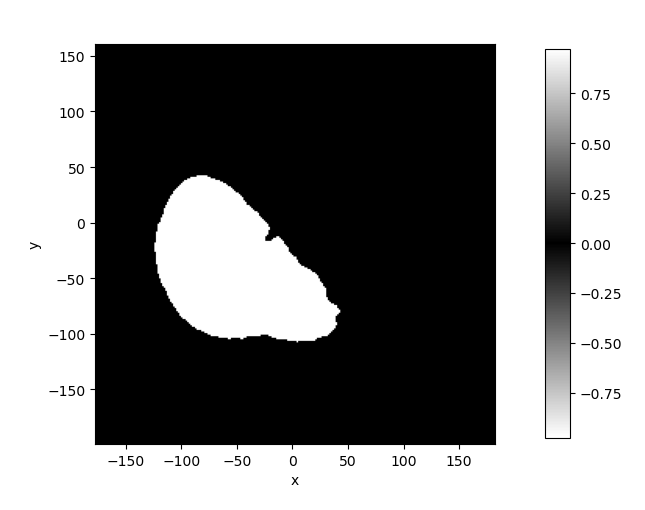

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [149]:
%autoreload
patient.view(compare=True)